In [2]:
# Load paths
data_tag = "England_Scotland_N.Ireland"
path_to_features = f"/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/MumPredictPreprocessing/diagnosis_{data_tag}.csv"  
# Save paths
path_to_model = f"/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_SAIL_comparison/" 
path_to_figs = path_to_model + 'plots/'

import os
os.chdir('/rds/homes/g/gaddcz/Projects/mum-predict-repos/mmVAE/src/')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from experiment import fit_restarts
from plot_wrappers import plot_restarts
import helpers

torch.manual_seed(0)
np.random.seed(0)
%matplotlib inline

# Load CPRD data
Here we load the CPRD data from outside the repository. 
We then re-order the the columns (which won't affect modelling) to  aid visualisation later. 
Finally we remove non-multimorbidity cases (with fewer than 2 conditions)

In [3]:
diag_frame = pd.read_csv(path_to_features)[helpers.get_column_order()]

# Remove some additional samples - these are patients with only one condition at the randomly selected pregnancy.
# print(np.where(diag_frame.sum(axis = 1) < 2)[0])        
np.savetxt(f"/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/MumPredictPreprocessing/mm_cases_{data_tag}.txt", np.where(diag_frame.sum(axis = 1) >= 2)[0])
diag_frame = diag_frame[diag_frame.sum(axis = 1) >= 2]

diag_frame.columns = helpers.get_column_order(plot=True)
diag_frame.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')

N = diag_frame.shape[0]
D = diag_frame.shape[1]

# Check prevalence of diseases
print(list(zip(diag_frame.columns, diag_frame.to_numpy().sum(axis=0))))

print(f"\n We have {N} training samples, and {D} conditions")


[('Cancer', 2483), ('Asthma', 72814), ('Allergic Rhin Conj', 78945), ('Migraine', 56238), ('Anxiety', 81667), ('Depression', 112863), ('Substance misuse', 9865), ('Alcohol problem', 4758), ('Eating disorder', 10129), ('SMHmm', 9596), ('Other mental', 39754), ('Other headache', 20270), ('AdrenalAll', 56), ('Pituitary', 1685), ('PCOS', 17251), ('Sarcoid', 231), ('Leiomyoma', 2889), ('Endometriosis', 8792), ('Retinal detachment', 403), ('PTH', 102), ('Heart failure', 325), ('IHD/MI', 578), ('Stroke', 849), ('Interstitial lung', 43), ('Blind', 91), ('COPD', 271), ('Solid organ transplant', 157), ('Bronchiectasis', 337), ('Neuro development', 2192), ('Atopic eczema', 13986), ('Cardiomyopathy', 173), ('Cystic fybrosis', 224), ('Sickle cell', 113), ('Pulminary Heart', 40), ('IBS', 42850), ('Turners syndrome', 47), ('Marfan syndrome', 109), ('Diabetes', 4257), ('Diabetes (retino)', 1450), ('Hypertension', 5893), ('Spina bifida', 531), ('Congenital Heart', 2343), ('Vertebrae', 5157), ('Thyroid'

# Run experiment

Plot order
* the prevalence of each condition in each quantised cluster
* the log odds ratio of each quantised cluster
* the cluster factor association matrix
* the prevalence within factors
* the log odds ratio within factors




England_Scotland_N_Ireland_BetaNeg0_40_L15_batch1024


Loaded /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_SAIL_comparison/England_Scotland_N_Ireland_BetaNeg0_40_L15_batch1024.pickle, seed 0
Loaded /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_SAIL_comparison/England_Scotland_N_Ireland_BetaNeg0_40_L15_batch1024.pickle, seed 1
Loaded /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_SAIL_comparison/England_Scotland_N_Ireland_BetaNeg0_40_L15_batch1024.pickle, seed 2
Averaged adjusted mutual information score over 3 seeds
 0.9429222709215228 +- 0.027728216509777408
Taking seed 2 


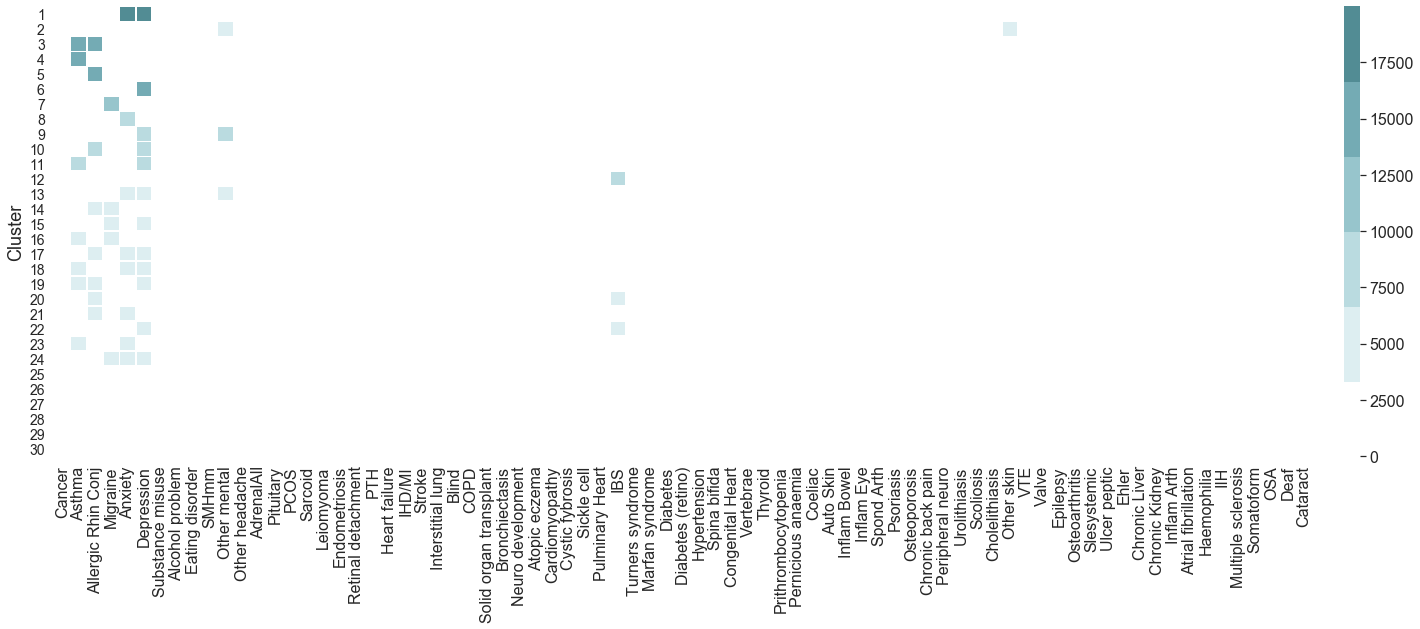

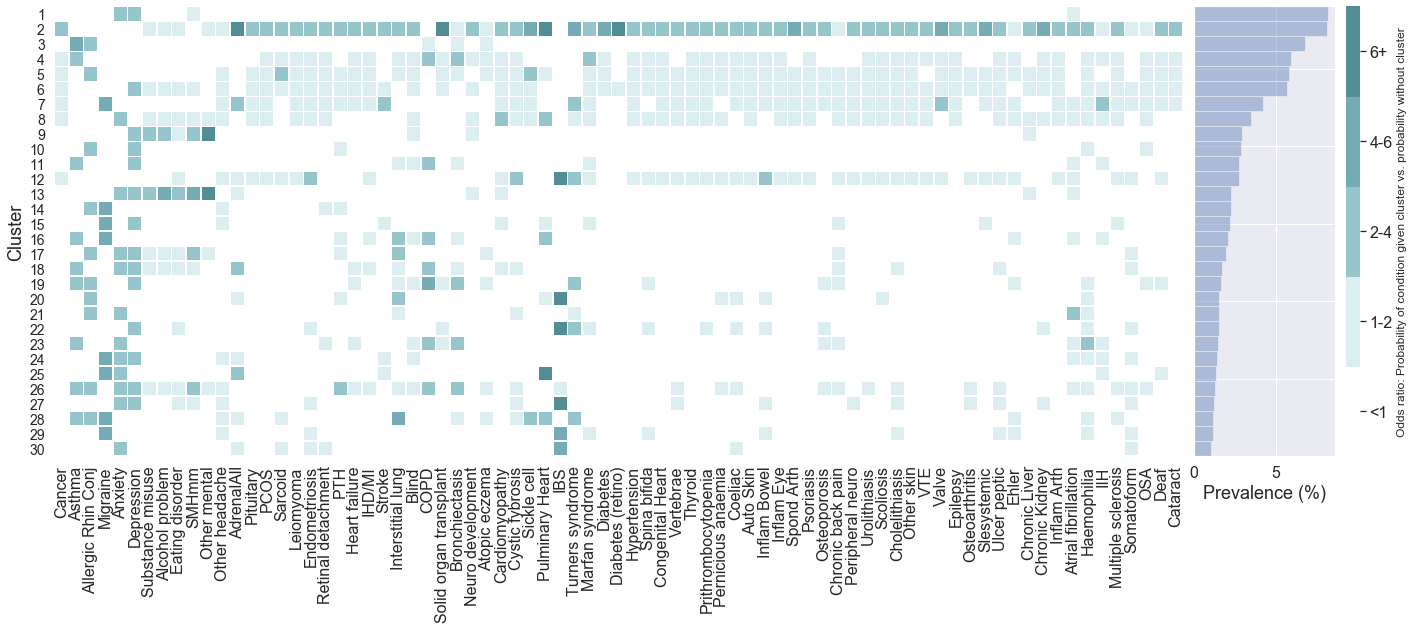

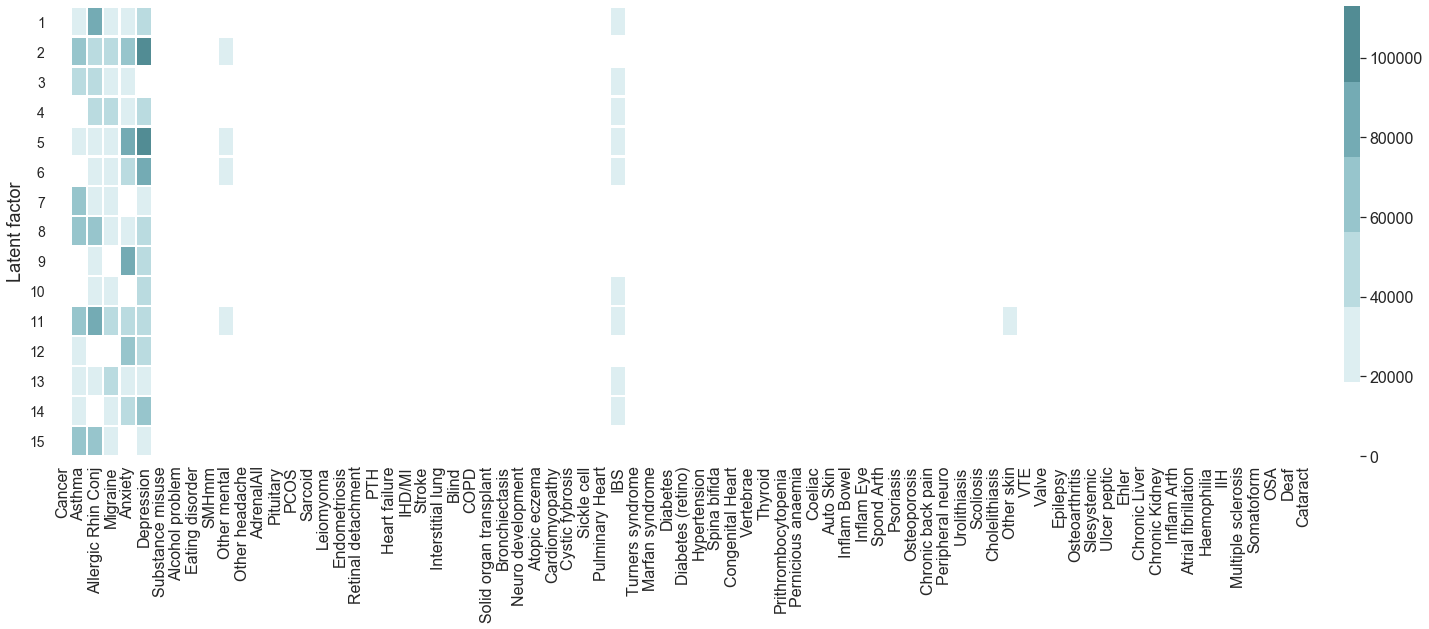

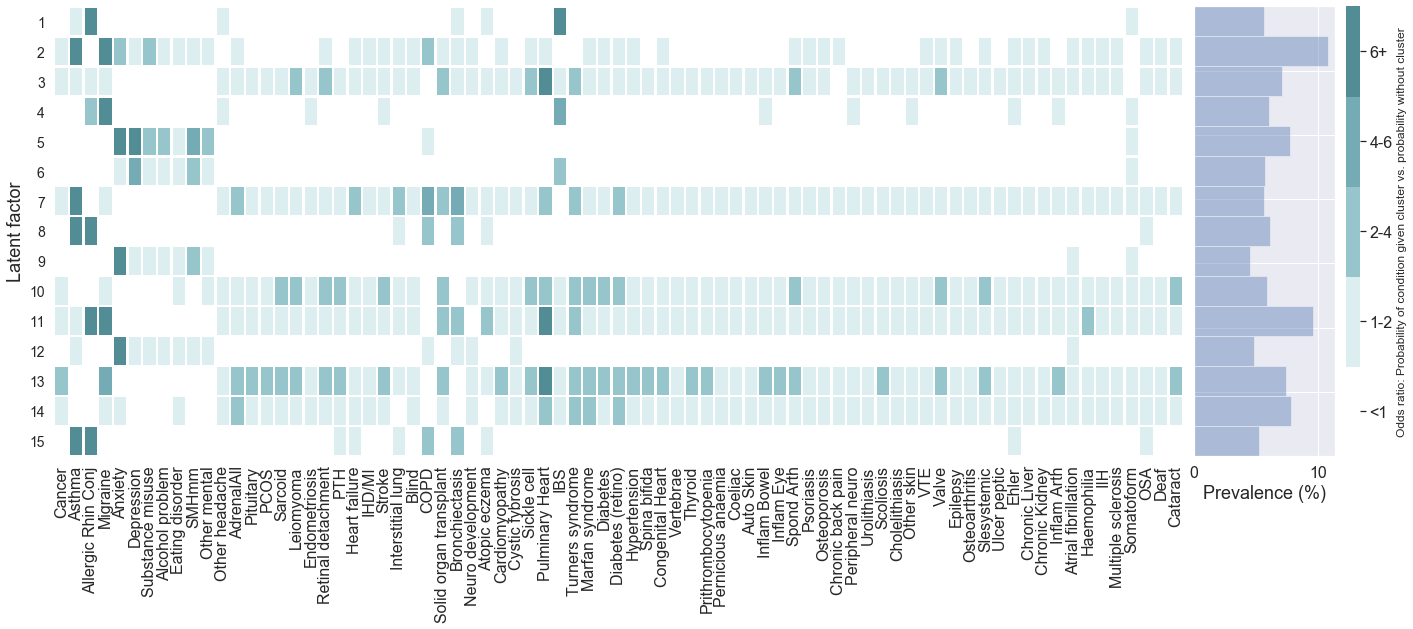

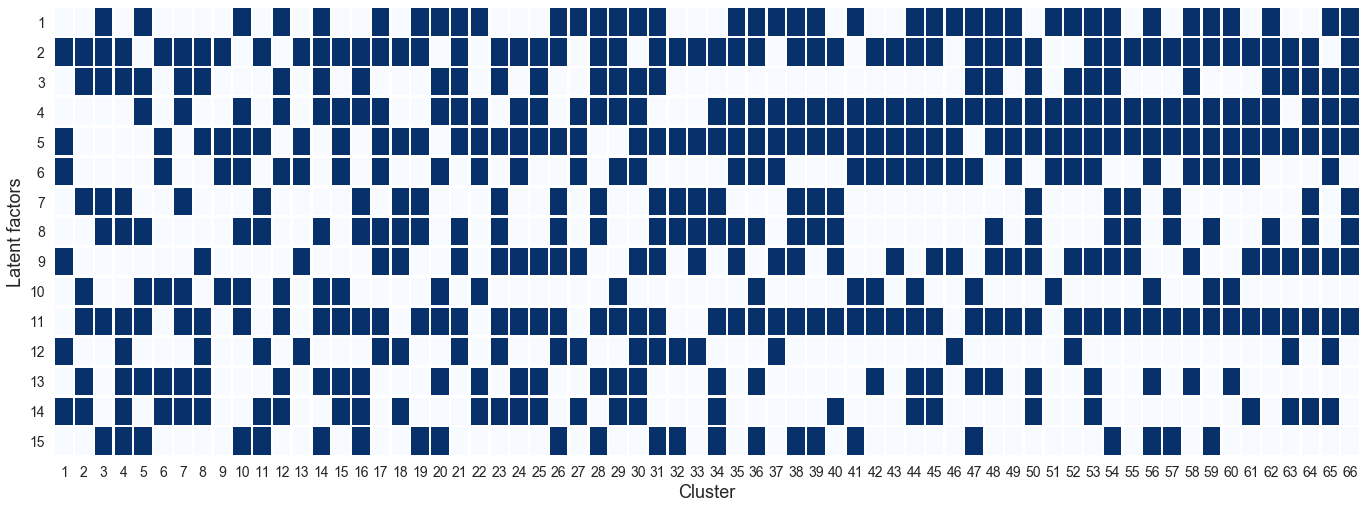

In [4]:
for L in [15]:
    for batch_size in [1024]:
        architecture = {'enc_h': [D, D, D, L], 
                        'dec_h': [L, D, D, D], 
                        'constrain': ['L0', 'L0'],
                       }
        model_params = {'tmp_schedule': [4, 0.4, 0.4],
                         'epochs': 50,
                         'batch_size': batch_size,
                         'lr': 1e-3,
                         'verbose': 1,
                         'anneal': True,
                         'norm_beta': -0.4
                        }



        method_name = f'{data_tag}_Beta{model_params["norm_beta"]:.2f}_L{L}_batch{batch_size}'.replace(".", "_").replace("-", "Neg")
        
        print(f"\n\n{method_name}\n===============\n\n")

        all_dicts, losses, labels, avg_ami = fit_restarts(diag_frame, architecture, model_params,
                                                          n_restarts=3,
                                                          save_path=f"{path_to_model}{method_name}",
                                                          force_retrain=False
                                                         )
        
        plot_restarts(diag_frame, all_dicts, losses, labels, plot_path=f"{path_to_figs}{method_name}")

